# Data Cube of transmissions : Fit with Gaussian Processes

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : January 7th 2027  
- update : January 10th 2021

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
import scipy
from scipy import interpolate

In [2]:
import os

In [3]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/users/dagoret/anaconda3/bin/python
3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel, ConstantKernel

In [5]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
#plt.rcParams['axes.formatter.useroffset']=  False

In [6]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [7]:
!ls data

20200211-holo-4-003-uniformity-datacube.npy


# Configuration

In [8]:
WL=np.arange(380,1080)
NWL=len(WL)

In [9]:
XMIN = -4.5
XMAX = 4.5
YMIN = -4.5
YMAX = 4.5
NX=50
NY=50
xx=np.linspace(XMIN,XMAX,NX)
yy=np.linspace(YMIN,YMAX,NY)

In [10]:
grid_x, grid_y = np.mgrid[XMIN:XMAX:50j, YMIN:YMAX:50j]

In [11]:
cmap="jet"

# Utility Functions

In [12]:
# Increase the number of iteration inside the GaussuanProcessRegressor
#https://stackoverflow.com/questions/62376164/how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
from sklearn.utils.optimize import _check_optimize_result
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

In [13]:
def get_list_of_position(arr):
    """
    Return the list of positions
    """
    
    
    ListOfPositions = [] 
    arrsize=len(arr)
    Npos=0
    
    for idx in np.arange(arrsize):
    
        currentposition = (arr[idx][1], arr[idx][2] )
    
        if currentposition not in ListOfPositions:
            ListOfPositions.append(currentposition)
            Npos+=1
            
            
    return Npos, ListOfPositions
    

In [14]:
def get_list_of_transmissions(arr):
    """
    
    """
    
    Narr=len(arr)
    Npos,list_of_position = get_list_of_position(arr)
    
    collectedtransmissions = np.empty(Npos, dtype=np.object)
    
    for idx in np.arange(Narr):   
        currentposition = (arr[idx][1], arr[idx][2])
        currentvalues = (arr[idx][3],arr[idx][4], arr[idx][5] )
  
    
        idx2=-1
        for position in list_of_position:
            idx2+=1
            
            if position == currentposition:
            
                if collectedtransmissions[idx2] == None:
                    collectedtransmissions[idx2] = []
                    collectedtransmissions[idx2].append(currentvalues)
                else:
                    collectedtransmissions[idx2].append(currentvalues)
                       
    
    return collectedtransmissions    
       

In [15]:
def find_nearest_point(list_of_points,x0=0,y0=0):
    
    N=len(list_of_points)
    distances = []
    
    for pos in list_of_points:
        dx=pos[0]-x0
        dy=pos[1]-y0
        distances.append(np.sqrt(dx**2 + dy**2))
    
    distances = np.array(distances)
    
    idx0 = np.where(distances == distances.min())[0][0]
    
    return idx0,distances[idx0]
    

In [16]:
def get_transmission_center(arr,x0=0,y0=0):
    """
    return the transmission of existing position (x0,y0) 
    
    """
    
    wl0 = np.array([], dtype=np.float64)
    eff0 = np.array([], dtype=np.float64)
    eeff0 = np.array([], dtype=np.float64)
    
    Npos,list_of_position = get_list_of_position(arr)
    arr_ext = get_list_of_transmissions(arr)
    
    idx0,d0=find_nearest_point(list_of_position,x0=x0,y0=y0)
     
    
    # loop on different positions
    for idx in np.arange(Npos):    
        list_of_datapoints = arr_ext[idx]
        x,y = list_of_position[idx]
    
        if idx==idx0:
            wl,eff,eeff = zip(*list_of_datapoints)   
            wl0 = wl
            eff0 = eff
            eeff0 =eeff          
        
    return wl0,eff0,eeff0
       

# Read Input file

In [17]:
datadir="data"
files_list= os.listdir(datadir)
print(files_list)
filename=files_list[0]
fullfilename=os.path.join(datadir,filename)
print(fullfilename)

['20200211-holo-4-003-uniformity-datacube.npy']
data/20200211-holo-4-003-uniformity-datacube.npy


In [18]:
arr=np.load(fullfilename)

In [19]:
arr.shape

(3443,)

In [20]:
NARR=arr.shape[0]

In [21]:
arr

array([(0,  0.,  0., 400.014, 0.28404813, 7.02226350e-04),
       (0,  0.,  0., 419.989, 0.09057611, 2.22853061e-04),
       (0,  0.,  0., 440.023, 0.02899506, 5.77351450e-05), ...,
       (2, -4., -4., 519.984, 0.06957727, 9.21319092e-05),
       (2, -4., -4., 540.001, 0.05970568, 7.87463120e-05),
       (2, -4., -4., 559.997, 0.03172864, 4.54447038e-05)],
      dtype=[('order', '<i8'), ('dx', '<f8'), ('dy', '<f8'), ('wl', '<f8'), ('DE', '<f8'), ('DE_std', '<f8')])

In [22]:
order0 = arr["order"]== 0
order1 = arr["order"]== 1
order2 = arr["order"]== 2

In [23]:
arr_0 = arr[order0]
arr_1 = arr[order1]
arr_2 = arr[order2]

# Order 1

## List of positions

In [24]:
Npos1,list_of_position_1 = get_list_of_position(arr_1)

In [25]:
Npos1

48

In [26]:
print(list_of_position_1)

[(0.0, 0.0), (0.0, 1.0), (0.0, 2.0), (0.0, 4.0), (0.0, -1.0), (0.0, -2.0), (0.0, -4.0), (1.0, 0.0), (1.0, 1.0), (1.0, 2.0), (1.0, 4.0), (1.0, -1.0), (1.0, -2.0), (1.0, -4.0), (2.0, 0.0), (2.0, 1.0), (2.0, 2.0), (2.0, 4.0), (2.0, -1.0), (2.0, -2.0), (2.0, -4.0), (4.0, 0.0), (4.0, 1.0), (4.0, 2.0), (4.0, 4.0), (4.0, -1.0), (4.0, -2.0), (-1.0, 0.0), (-1.0, 1.0), (-1.0, 2.0), (-1.0, 4.0), (-1.0, -1.0), (-1.0, -2.0), (-1.0, -4.0), (-2.0, 0.0), (-2.0, 1.0), (-2.0, 2.0), (-2.0, 4.0), (-2.0, -1.0), (-2.0, -2.0), (-2.0, -4.0), (-4.0, 0.0), (-4.0, 1.0), (-4.0, 2.0), (-4.0, 4.0), (-4.0, -1.0), (-4.0, -2.0), (-4.0, -4.0)]


In [27]:
len(list_of_position_1)

48

## Find the list of different positions

In [28]:
arr_1_ext = get_list_of_transmissions(arr_1)

<ipython-input-14-466b74409715>:9: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  collectedtransmissions = np.empty(Npos, dtype=np.object)


In [29]:
len(arr_1_ext)

48

## Plot transmissions

In [30]:
from matplotlib import cm, colors
values = np.linspace(-4.0, 4.0, 10)
norm = colors.Normalize(vmin=-4.0, vmax=4.0, clip=False)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.bwr)
for value in values:
   print("%.2f" % value, "=",
      "red:%.2f" % mapper.to_rgba(value)[0],
      "green:%.2f" % mapper.to_rgba(value)[1],
      "blue:%.2f" % mapper.to_rgba(value)[2])

-4.00 = red:0.00 green:0.00 blue:1.00
-3.11 = red:0.22 green:0.22 blue:1.00
-2.22 = red:0.44 green:0.44 blue:1.00
-1.33 = red:0.67 green:0.67 blue:1.00
-0.44 = red:0.89 green:0.89 blue:1.00
0.44 = red:1.00 green:0.89 blue:0.89
1.33 = red:1.00 green:0.67 blue:0.67
2.22 = red:1.00 green:0.44 blue:0.44
3.11 = red:1.00 green:0.22 blue:0.22
4.00 = red:1.00 green:0.00 blue:0.00


Text(0.5, 0.98, 'Transmission for Order 1')

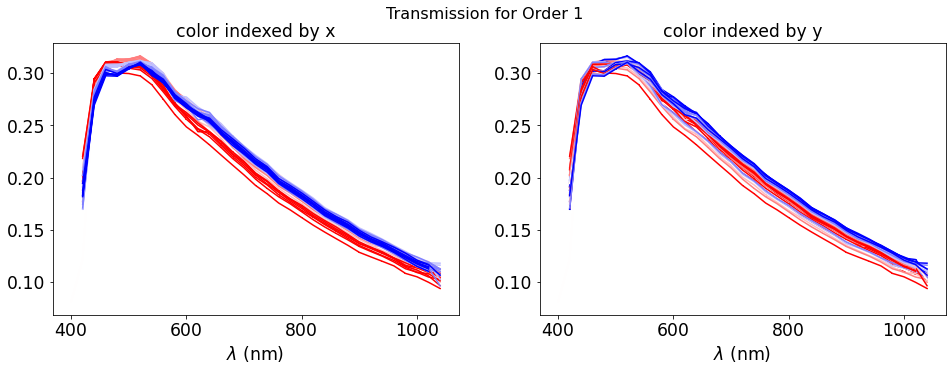

In [31]:
fig=plt.figure(figsize=(16,5))

fig.add_subplot(1,2,1)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(x)
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    if x==0 and y==0:
        wl0 = wl
        eff0 = eff
        f0 = interpolate.interp1d(wl0, eff0,kind='cubic')
    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)
    plt.errorbar(wl,eff,yerr=eeff,color=c)  
    plt.title("color indexed by x")
    plt.xlabel("$\lambda$ (nm)")
 
fig.add_subplot(1,2,2)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(y)
    wl,eff,eeff = zip(*list_of_datapoints)    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)  
    plt.errorbar(wl,eff,yerr=eeff,color=c)  
    plt.title("color indexed by y")
    plt.xlabel("$\lambda$ (nm)")
    
plt.suptitle("Transmission for Order 1",fontsize=16)  

Text(0.5, 0.98, 'Transmission ratio for Order 1')

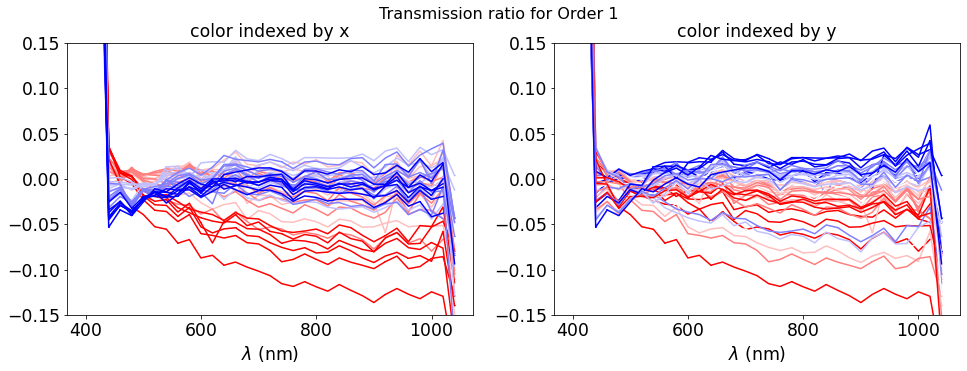

In [32]:
fig=plt.figure(figsize=(16,5))

fig.add_subplot(1,2,1)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    
        
    c = mapper.to_rgba(x)
    wl,eff,eeff = zip(*list_of_datapoints) 
    
    f = interpolate.interp1d(wl, eff,kind='cubic')
    
    effr = f(wl)/f0(wl)-1 
    eeffr = eeff/f0(wl) 

    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)
    plt.errorbar(wl,effr,yerr=eeff,color=c)  
    plt.title("color indexed by x")
    plt.xlabel("$\lambda$ (nm)")
    plt.ylim(-0.15,0.15)
 
fig.add_subplot(1,2,2)

for idx in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx]
    x,y = list_of_position_1[idx]
    c = mapper.to_rgba(y)
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    f = interpolate.interp1d(wl, eff,kind='cubic')
    
    effr = f(wl)/f0(wl) -1
    eeffr = eeff/f0(wl) 

    
    #plt.errorbar(wl,eff,yerr=eeff,color=c,uplims=True, lolims=True)  
    plt.errorbar(wl,effr,yerr=eeff,color=c)  
    plt.title("color indexed by y")
    plt.xlabel("$\lambda$ (nm)")
    plt.ylim(-0.15,0.15)
    
plt.suptitle("Transmission ratio for Order 1",fontsize=16)  

# Fit with Gaussian Process

## Fit 1D Gaussian Process

In [33]:
idx_sel = 0

In [34]:
list_of_datapoints = arr_1_ext[idx_sel]
x,y = list_of_position_1[idx_sel]
wl,eff,eeff = zip(*list_of_datapoints)  

In [35]:
wl=np.array(wl)
eff=np.array(eff)
eeff=np.array(eeff)

In [36]:
N=len(wl)

<ErrorbarContainer object of 3 artists>

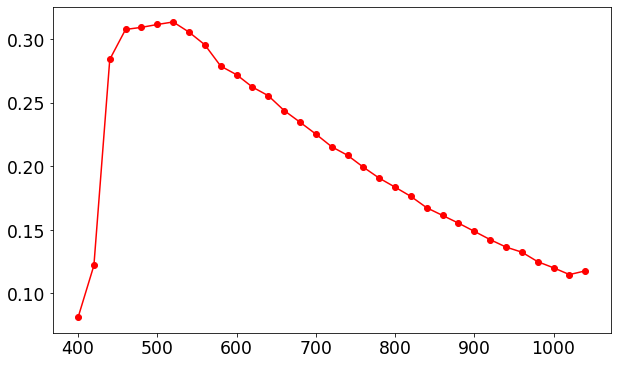

In [37]:
plt.errorbar(wl,eff,yerr=eeff,marker="o",ecolor="grey",color="r")

### utility functions

In [38]:
def fitGPTransmission(wl,eff,efferr,errorfactor=1):
    
    wl=np.array(wl)
    eff=np.array(eff)
    eeff=np.array(efferr)*errorfactor
    
    N=len(wl)
    
    kernel = 1 * RBF(length_scale=33.0, length_scale_bounds=(1e-1, 1e3))    
    #kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))* RBF(length_scale=33.0, length_scale_bounds=(1e-1, 1e3)) 
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=eeff ** 2, n_restarts_optimizer=0)
    #gaussian_process = MyGPR(kernel=kernel, alpha=eeff ** 2, n_restarts_optimizer=9)
    
    X_train = wl.reshape((N,1))
    y_train = eff
    
    X = WL.reshape((NWL,1))
    gaussian_process.fit(X_train, y_train)
    
    #print(gaussian_process.kernel_)
    
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    
    return mean_prediction, std_prediction, gaussian_process.kernel_

In [39]:
def plotfitGPTransmission(wl,eff,efferr,errorfactor=1,ax=None):
    
    mean_prediction, std_prediction, kparams  = fitGPTransmission(wl,eff,efferr,errorfactor=errorfactor)
    
    if ax == None:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
        
    ax.errorbar(wl,eff,yerr=eeff,marker="o",ecolor="k",color="r",label="Observations")
    ax.plot(WL, mean_prediction, label="Mean prediction")
    ax.fill_between(
        WL,
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",color="cyan"
    )
    ax.legend()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("transmission efficiency")
    ax.set_title(f"GP regression on efficiency at position {idx_sel} : (x,y) = ({x},{y})")
    ax.set_ylim(0.,0.5)
    
    

### 1D fit on the selected point

In [40]:
mean_prediction, std_prediction, k =  fitGPTransmission(wl,eff,eeff,errorfactor=1)

In [41]:
k.get_params()

{'k1': 0.165**2,
 'k2': RBF(length_scale=29.9),
 'k1__constant_value': 0.027172046437077813,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 29.868816261317974,
 'k2__length_scale_bounds': (0.1, 1000.0)}

In [42]:
k.get_params()['k2__length_scale']

29.868816261317974

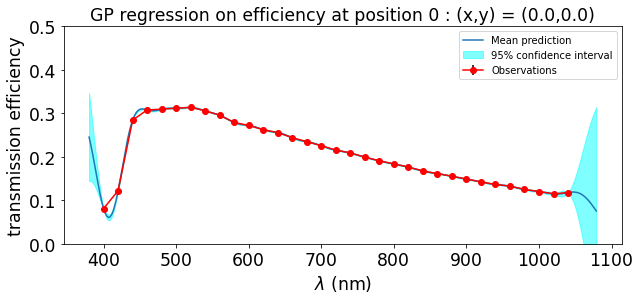

In [43]:
plotfitGPTransmission(wl,eff,eeff,errorfactor=1,ax=None)

### Loop on all points to fit a 1D gaussian process

/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


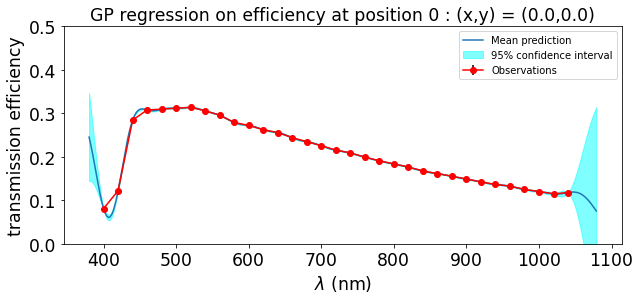

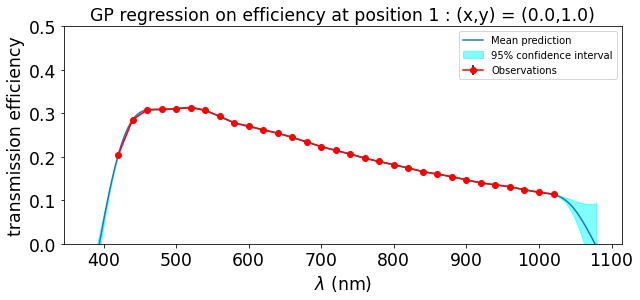

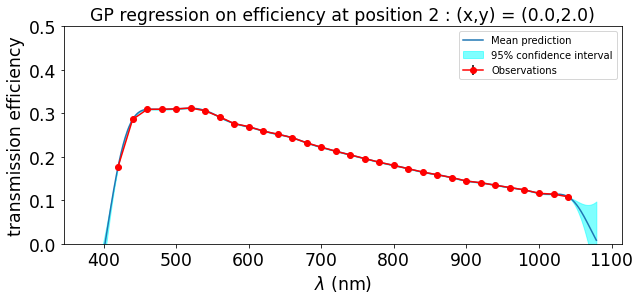

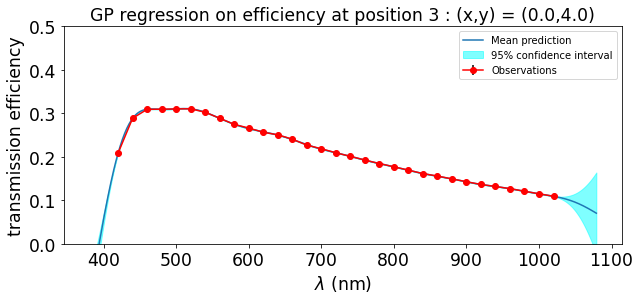

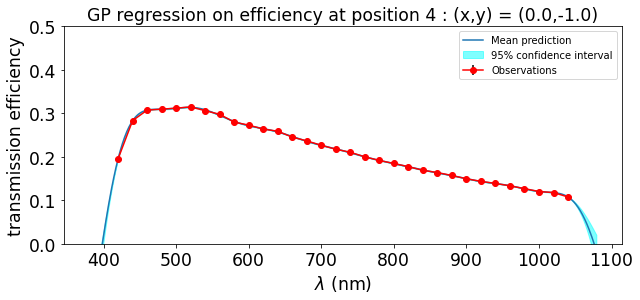

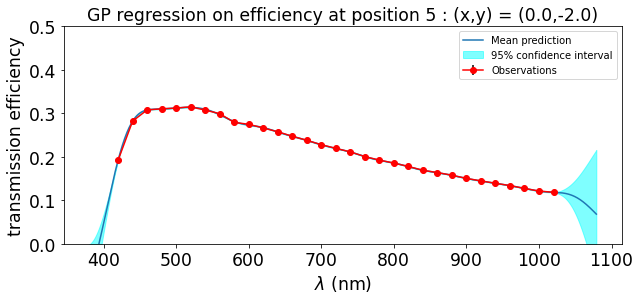

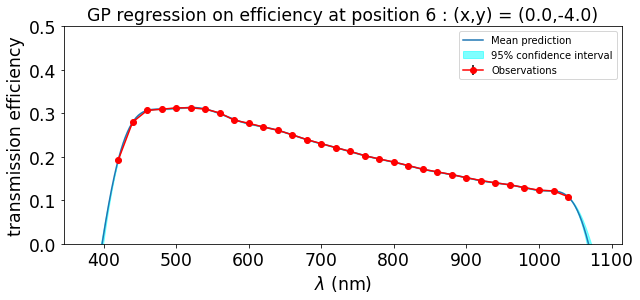

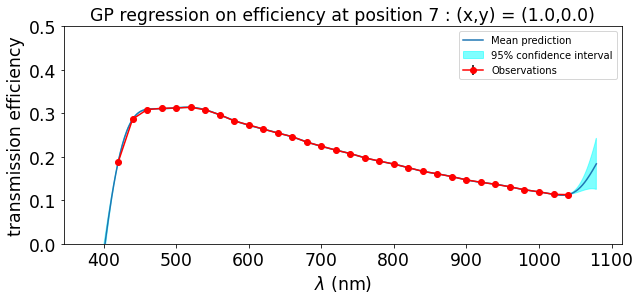

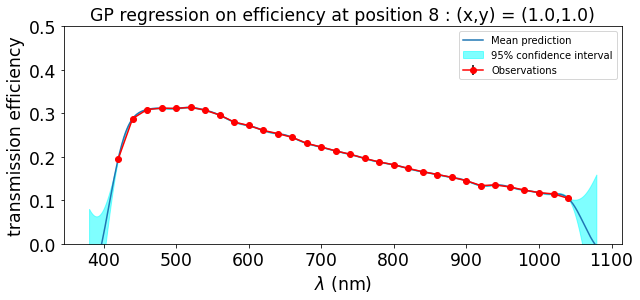

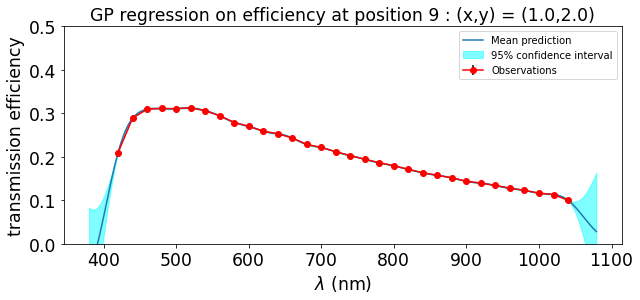

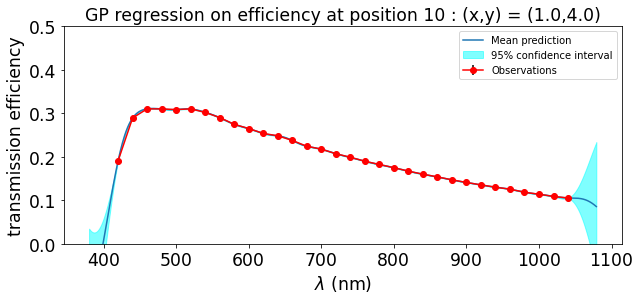

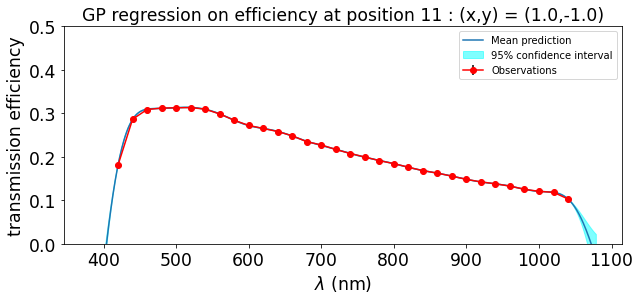

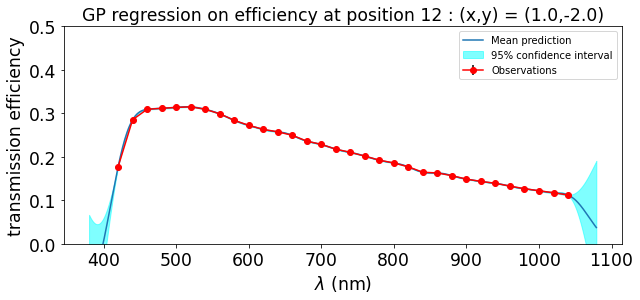

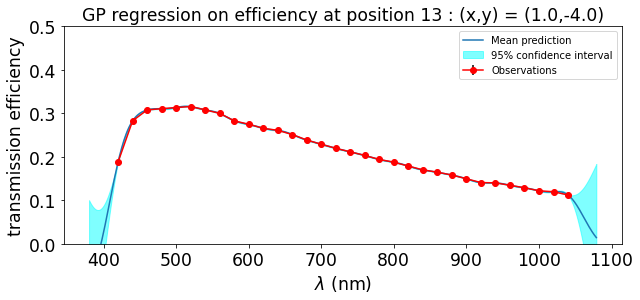

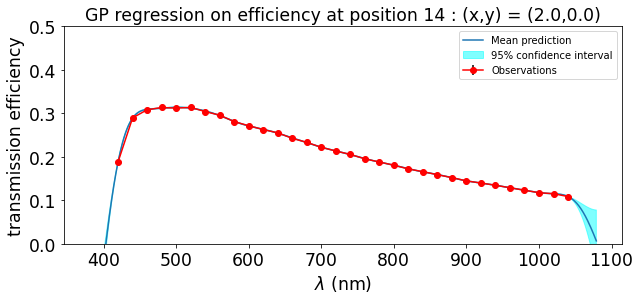

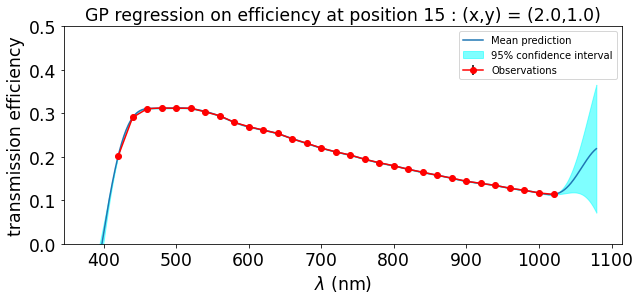

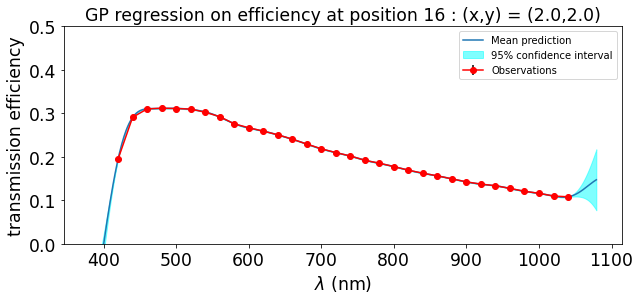

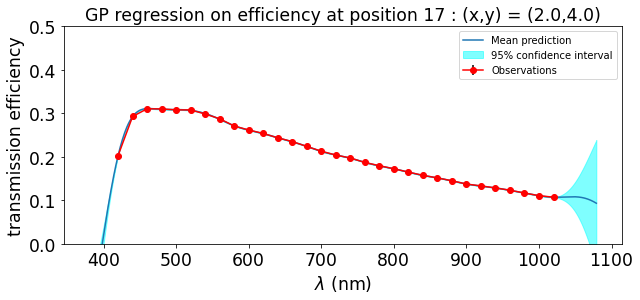

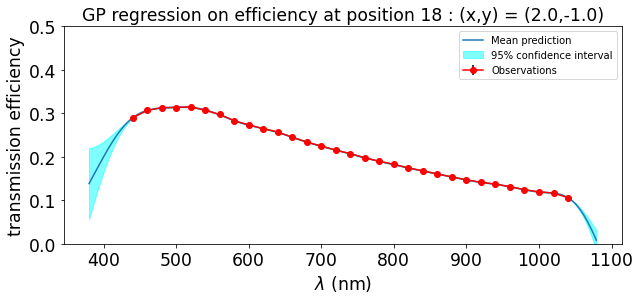

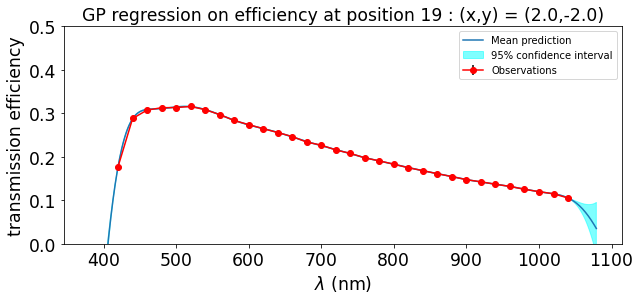

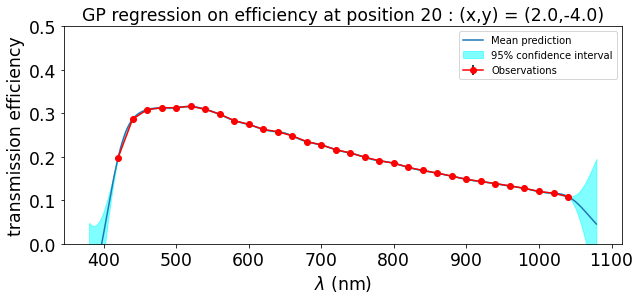

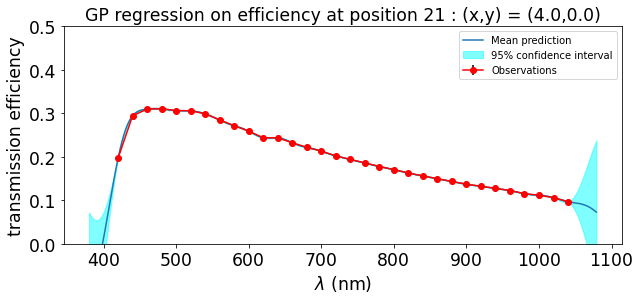

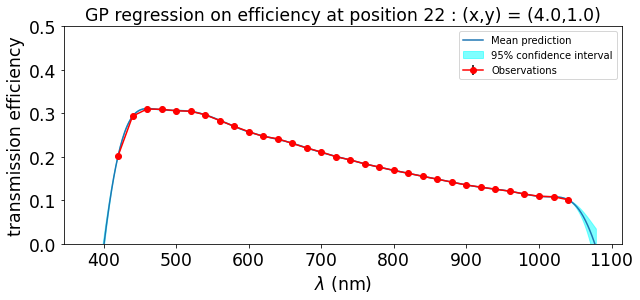

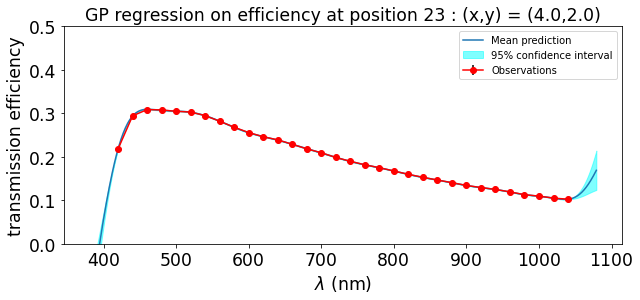

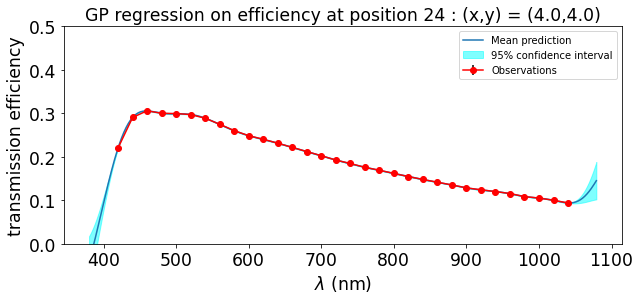

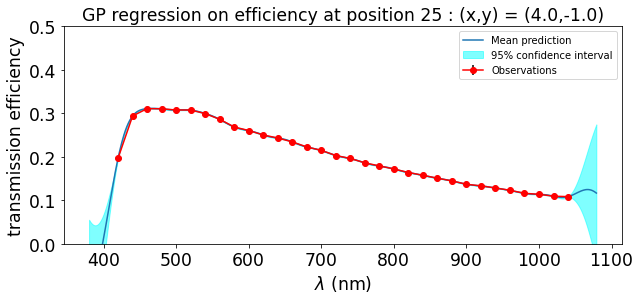

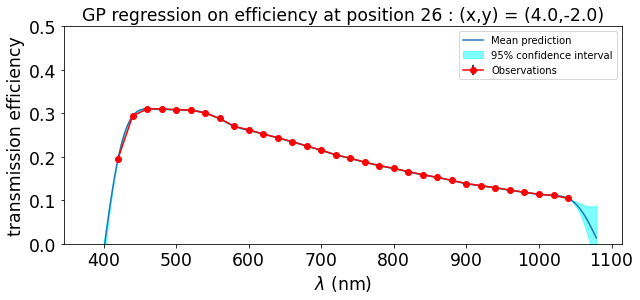

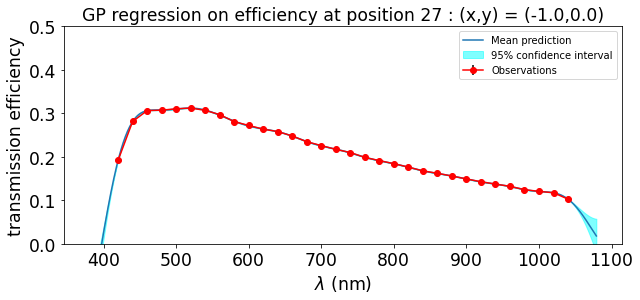

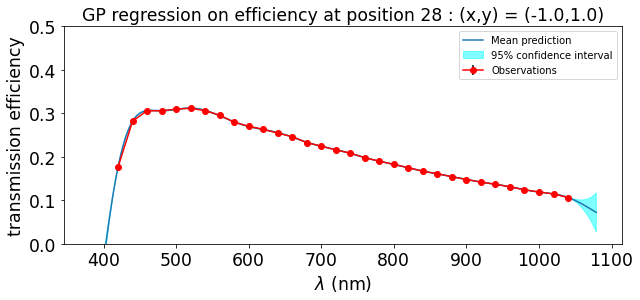

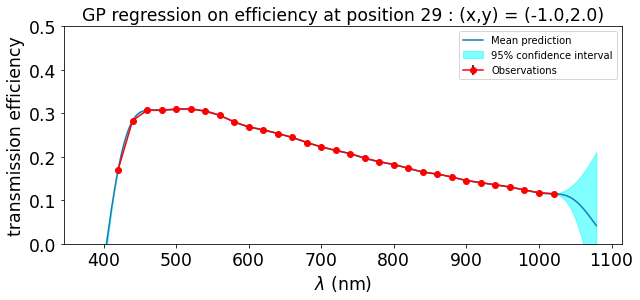

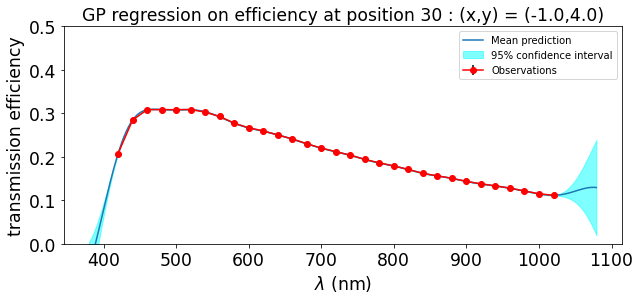

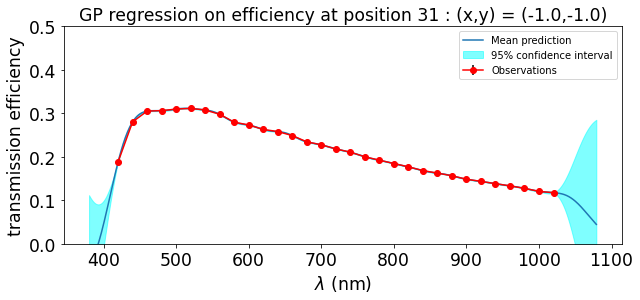

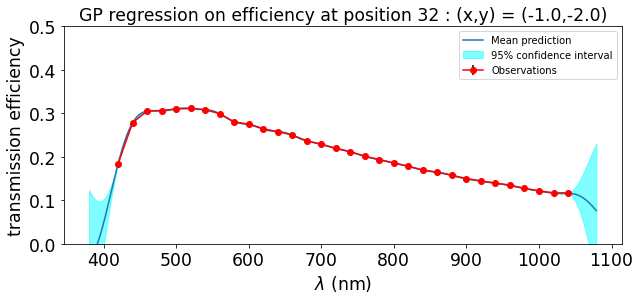

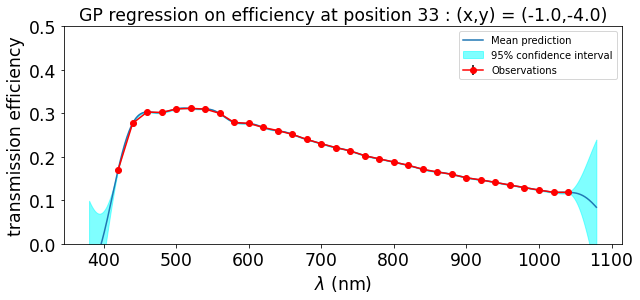

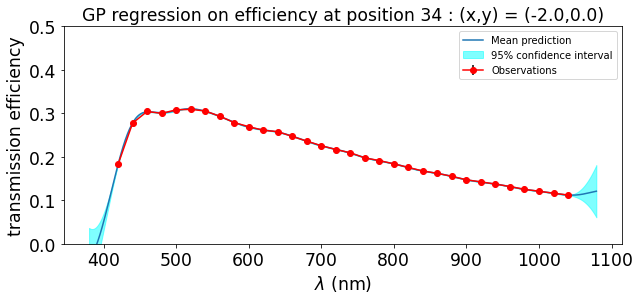

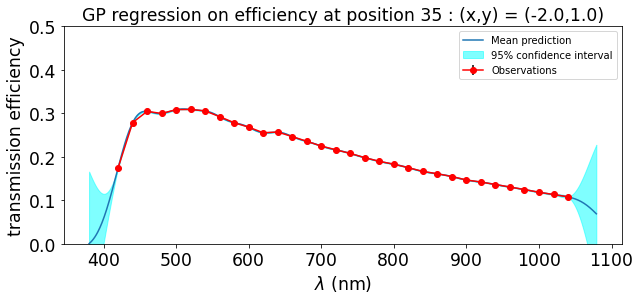

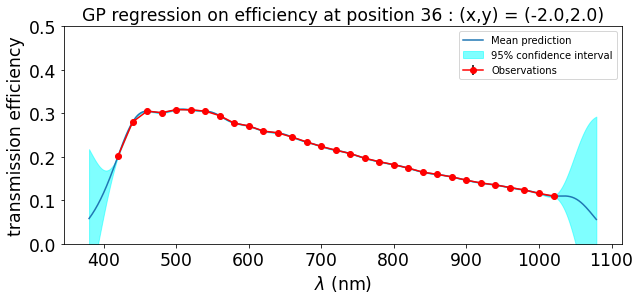

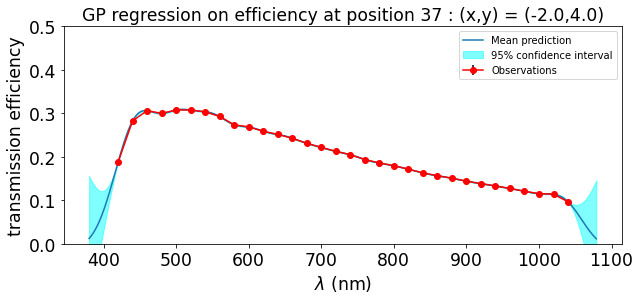

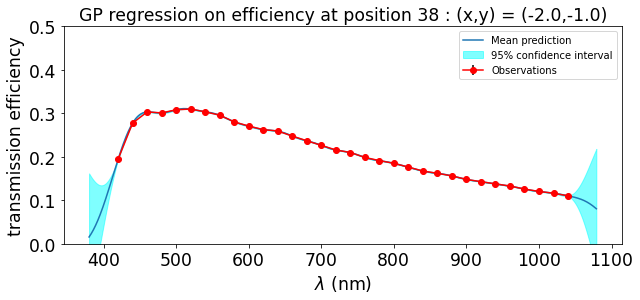

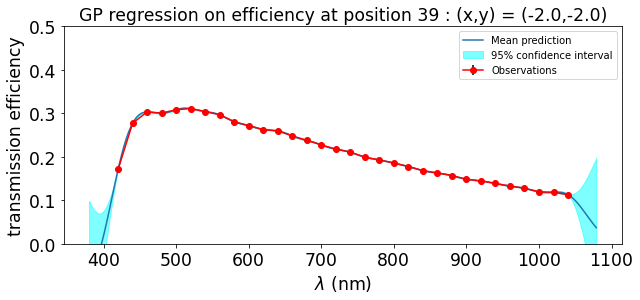

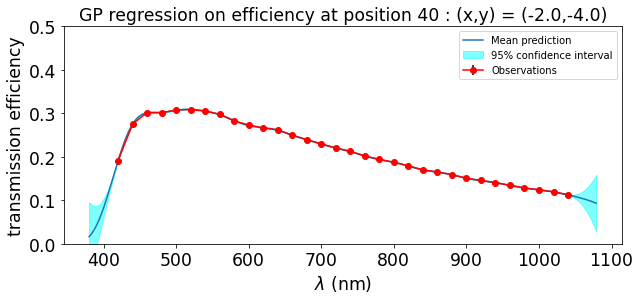

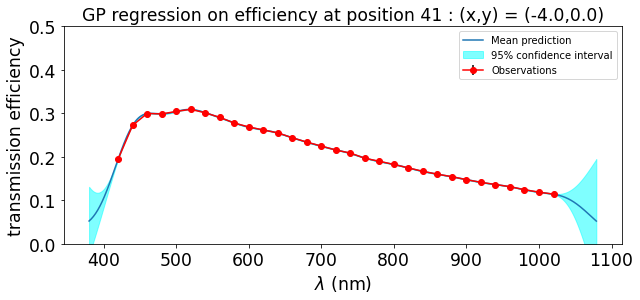

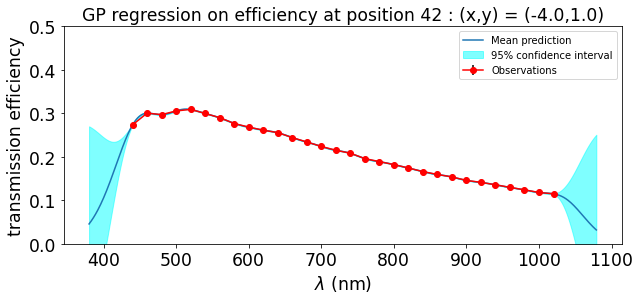

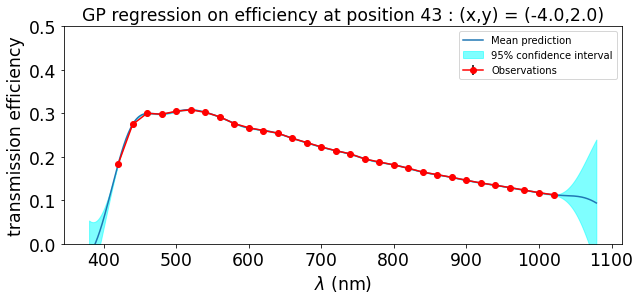

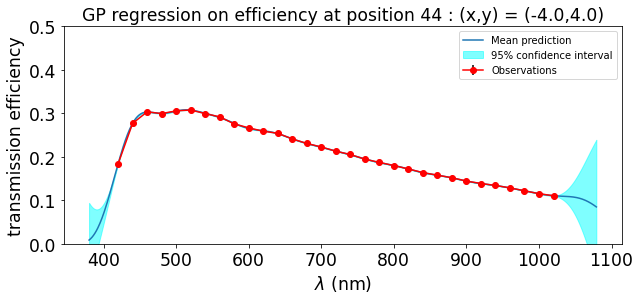

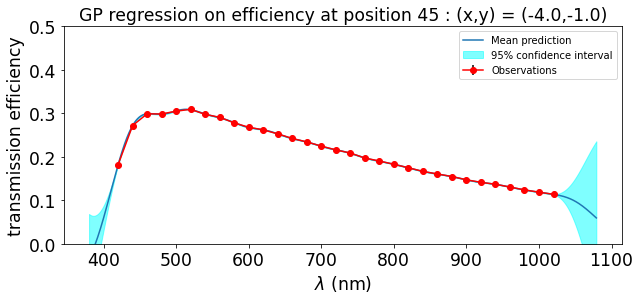

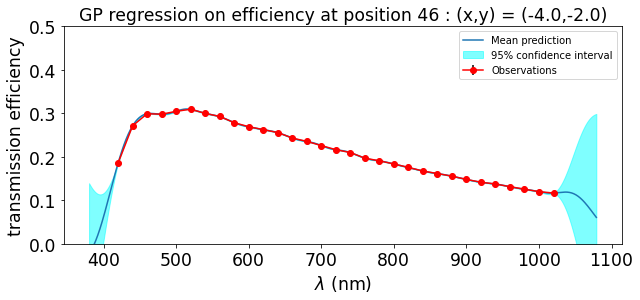

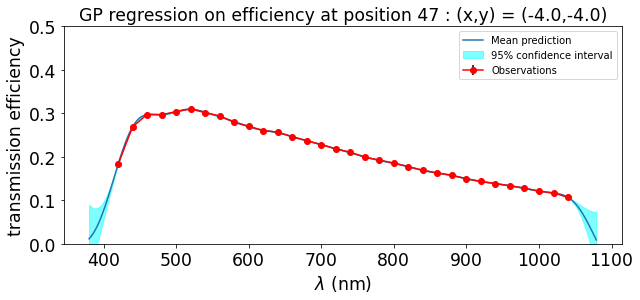

In [44]:
for idx_sel in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx_sel]
    x,y = list_of_position_1[idx_sel]
    wl,eff,eeff = zip(*list_of_datapoints)  
    plotfitGPTransmission(wl,eff,eeff,errorfactor=1,ax=None)
    

### Loop on all examples to find the hyper - parameters of the kernel

In [45]:
all_k1 = np.zeros(Npos1)
all_k2 = np.zeros(Npos1)
for idx_sel in np.arange(Npos1):    
    list_of_datapoints = arr_1_ext[idx_sel]
    x,y = list_of_position_1[idx_sel]
    wl,eff,eeff = zip(*list_of_datapoints)  
    
    
    mean_prediction, std_prediction, k  = fitGPTransmission(wl,eff,eeff,errorfactor=1)
    
    k1 = k.get_params()['k1__constant_value']
    k2 = k.get_params()['k2__length_scale']
    all_k1[idx_sel] = k1
    all_k2[idx_sel] = k2

/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [46]:
all_k1

array([0.02717205, 0.03321576, 0.02517993, 0.03340195, 0.08129663,
       0.02180972, 0.10324289, 0.05751946, 0.02058668, 0.01936256,
       0.0200726 , 0.11677599, 0.01979539, 0.02044869, 0.05781205,
       0.0327315 , 0.03137281, 0.02982062, 0.0246082 , 0.3744197 ,
       0.02096361, 0.01915459, 0.11880993, 0.04170731, 0.02456712,
       0.02039054, 0.03742647, 0.03806114, 0.07553517, 0.03375038,
       0.02155714, 0.02010131, 0.01959624, 0.02015171, 0.0221153 ,
       0.01894692, 0.01932873, 0.01869051, 0.01861228, 0.0195715 ,
       0.02045344, 0.01893148, 0.01895949, 0.02054873, 0.02069657,
       0.0191842 , 0.01924871, 0.02023202])

In [47]:
all_k2

array([29.86881626, 58.12231046, 42.96105188, 59.37740037, 65.6264591 ,
       46.43761263, 65.42401522, 54.40556288, 33.65421918, 35.88315024,
       34.9052785 , 59.43465585, 34.34940323, 33.17882629, 51.39299495,
       50.09488259, 47.71353592, 49.41215739, 66.01220408, 66.40894301,
       35.10433121, 33.05873313, 63.94035498, 56.4099308 , 53.57808618,
       34.13950861, 47.9049023 , 58.5425832 , 60.82637396, 47.64378333,
       52.32694829, 34.41329353, 34.13575374, 34.27312954, 47.88061715,
       33.55527674, 34.32376771, 35.70454963, 35.38410026, 33.66771036,
       46.21155661, 45.72499663, 36.28433455, 46.02550419, 44.93774631,
       41.47890613, 34.05124909, 46.27700656])

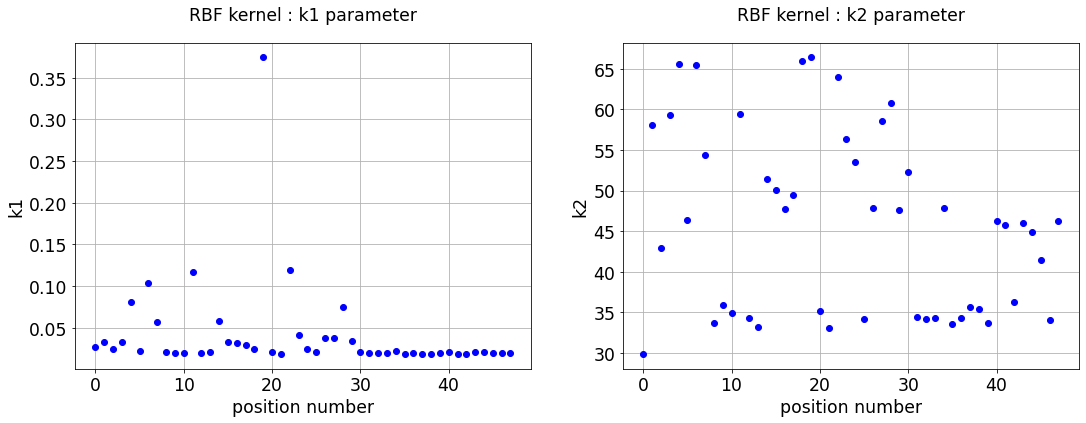

In [48]:
fig = plt.figure(figsize=(18,6))
ax=fig.add_subplot(1,2,1)
ax.plot(all_k1,'bo')
#plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("position number")
ax.set_ylabel("k1")
ax.set_title("RBF kernel : k1 parameter",y=1.05)
ax.grid()
ax=fig.add_subplot(1,2,2)
ax.plot(all_k2,'bo')
#plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("position number")
ax.set_ylabel("k2")
ax.set_title("RBF kernel : k2 parameter",y=1.05)
ax.grid()

## Fit 3D Gaussian Process

In [49]:
#https://stackoverflow.com/questions/62376164/how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
from sklearn.utils.optimize import _check_optimize_result
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

### create data arrays

In [50]:
arr_1

array([(1,  0.,  0.,  400.014, 0.08113432, 0.00042531),
       (1,  0.,  0.,  419.989, 0.12204722, 0.00055285),
       (1,  0.,  0.,  440.023, 0.28427847, 0.0003543 ), ...,
       (1, -4., -4.,  999.966, 0.12115345, 0.00016043),
       (1, -4., -4., 1019.98 , 0.11694063, 0.00014926),
       (1, -4., -4., 1040.023, 0.10674954, 0.00015927)],
      dtype=[('order', '<i8'), ('dx', '<f8'), ('dy', '<f8'), ('wl', '<f8'), ('DE', '<f8'), ('DE_std', '<f8')])

In [51]:
arr=arr_1
Narr = len(arr)
X = np.zeros((Narr,3))
Y = np.zeros(Narr)
EY = np.zeros(Narr)
for idx in np.arange(Narr):    

    X[idx,0]=arr[idx][1]
    X[idx,1]=arr[idx][2]
    X[idx,2]=arr[idx][3]
    
    Y[idx]=arr[idx][4]
    EY[idx] = arr[idx][5]

In [52]:
X

array([[   0.   ,    0.   ,  400.014],
       [   0.   ,    0.   ,  419.989],
       [   0.   ,    0.   ,  440.023],
       ...,
       [  -4.   ,   -4.   ,  999.966],
       [  -4.   ,   -4.   , 1019.98 ],
       [  -4.   ,   -4.   , 1040.023]])

In [53]:
Y

array([0.08113432, 0.12204722, 0.28427847, ..., 0.12115345, 0.11694063,
       0.10674954])

In [54]:
EY

array([0.00042531, 0.00055285, 0.0003543 , ..., 0.00016043, 0.00014926,
       0.00015927])

### kernel

In [55]:
kernel = RBF(length_scale=(1.0,1.0,45.0),length_scale_bounds =  (1e-2,1e3))

In [56]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=EY ** 2, n_restarts_optimizer=9)
#gaussian_process = MyGPR(kernel=kernel, alpha=EY ** 2, n_restarts_optimizer=9)

### Fit

In [57]:
gpr = gaussian_process.fit(X, Y)

In [58]:
kernel.get_params()

{'length_scale': (1.0, 1.0, 45.0), 'length_scale_bounds': (0.01, 1000.0)}

### Plot WL vs X

In [59]:
newx,newy = np.meshgrid(xx,WL)

In [60]:
newy

array([[ 380,  380,  380, ...,  380,  380,  380],
       [ 381,  381,  381, ...,  381,  381,  381],
       [ 382,  382,  382, ...,  382,  382,  382],
       ...,
       [1077, 1077, 1077, ..., 1077, 1077, 1077],
       [1078, 1078, 1078, ..., 1078, 1078, 1078],
       [1079, 1079, 1079, ..., 1079, 1079, 1079]])

In [61]:
N=np.ravel(newx).shape[0]
N

35000

In [62]:
N=np.ravel(newy).shape[0]
N

35000

In [63]:
y_position_value=0.0
y_fixed = np.full((N, ), y_position_value)

In [64]:
Xpred = np.stack([np.ravel(newx), y_fixed, np.ravel(newy)], axis=1)

In [65]:
Xpred

array([[  -4.5       ,    0.        ,  380.        ],
       [  -4.31632653,    0.        ,  380.        ],
       [  -4.13265306,    0.        ,  380.        ],
       ...,
       [   4.13265306,    0.        , 1079.        ],
       [   4.31632653,    0.        , 1079.        ],
       [   4.5       ,    0.        , 1079.        ]])

In [66]:
eff_gp3d_prediction , efferror_gp3d_prediction = gpr.predict(Xpred,return_std=True)

In [67]:
eff_gp3d_prediction [np.where(eff_gp3d_prediction<0)[0]] = 0
eff_gp3d_prediction [np.where(eff_gp3d_prediction>0.4)[0]] = 0

In [68]:
Z = eff_gp3d_prediction.reshape(newx.shape)

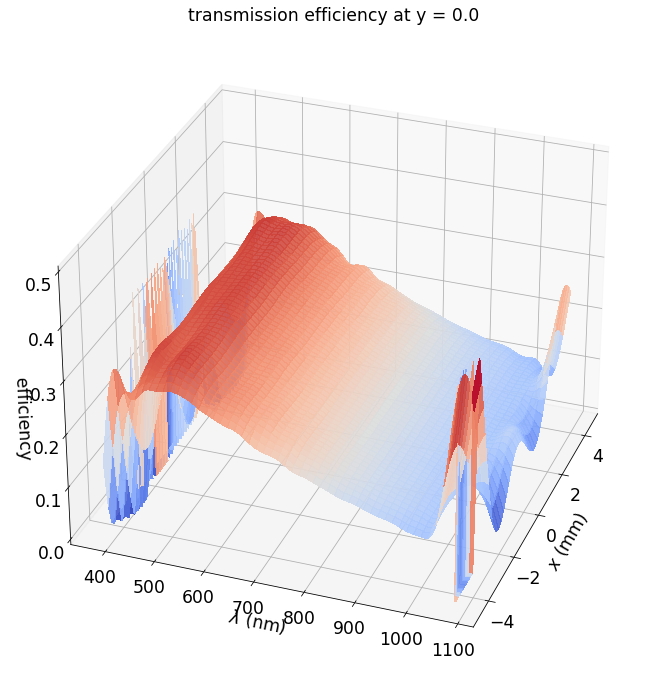

In [69]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(30, 20)
ax.plot_surface(newx, newy, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False, shade = True, alpha = 0.9)
#ax.clabel(cset, fontsize=9, inline=1)
ax.set_zlim(0,0.5)
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("$x$ (mm)")
ax.invert_xaxis()
ax.set_zlabel("efficiency")
ax.set_title(f"transmission efficiency at y = {y_position_value}")
plt.show()

### Plot WL vs y

In [70]:
newx,newy = np.meshgrid(yy,WL)

In [71]:
N=np.ravel(newx).shape[0]
N

35000

In [72]:
N=np.ravel(newy).shape[0]
N

35000

In [73]:
x_position_value=0
x_fixed = np.full((N, ), x_position_value)

In [74]:
Xpred = np.stack([x_fixed, np.ravel(newx) ,np.ravel(newy)], axis=1)

In [75]:
Xpred

array([[   0.        ,   -4.5       ,  380.        ],
       [   0.        ,   -4.31632653,  380.        ],
       [   0.        ,   -4.13265306,  380.        ],
       ...,
       [   0.        ,    4.13265306, 1079.        ],
       [   0.        ,    4.31632653, 1079.        ],
       [   0.        ,    4.5       , 1079.        ]])

In [76]:
eff_gp3d_prediction , efferror_gp3d_prediction = gpr.predict(Xpred,return_std=True)

In [77]:
eff_gp3d_prediction [np.where(eff_gp3d_prediction<0)[0]] = 0
eff_gp3d_prediction [np.where(eff_gp3d_prediction>0.4)[0]] = 0

In [78]:
Z = eff_gp3d_prediction.reshape(newx.shape)

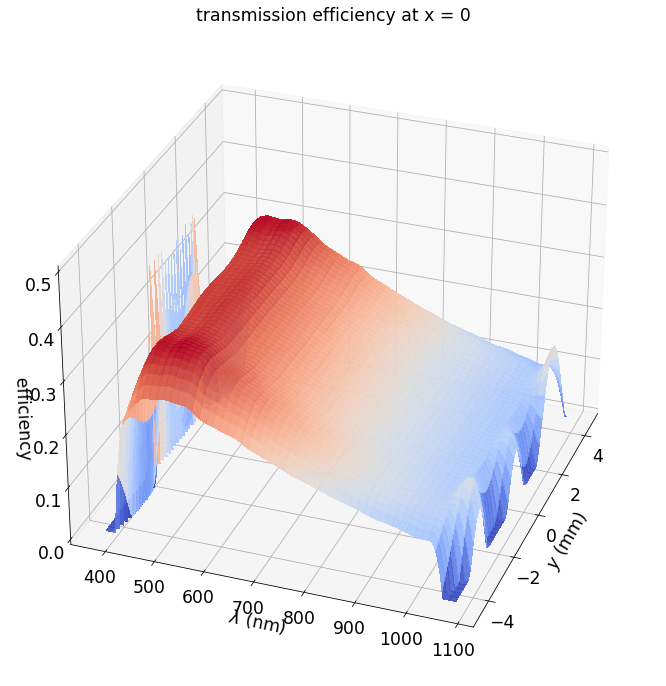

In [79]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(30, 20)
ax.plot_surface(newx, newy, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False, shade = True, alpha = 0.9)
#ax.clabel(cset, fontsize=9, inline=1)
ax.set_zlim(0,0.5)
ax.set_ylabel("$\lambda$ (nm)")
ax.set_xlabel("$y$ (mm)")
ax.invert_xaxis()
ax.set_zlabel("efficiency")
ax.set_title(f"transmission efficiency at x = {x_position_value}")
plt.show()